Point Probes
============

**Summary:**    Point-wise sampling of desired output variables where the output $q_{ijk}$ is defined as

$q_{m,ijk}(t) = f_m(r_i,\theta_j,\phi_k,t)$

for a desired output $f_m$ at coordinates $r_i, \theta_j, \phi_k$.

**Subdirectory:**  Point_Probes

**main_input prefix:** point_probe

**Python Class:**  Point_Probes 


**Additional Namelist Variables:**  

* point_probe_r  : radial indices for point-probe output

* point_probe_theta  : theta indices for point-probe output

* point_probe_phi : phi indices for point-probe output

* point_probe_r_nrm  : normalized radial coordinates for point-probe output

* point_probe_theta_nrm : normalized theta coordinates for point-probe output

* point_probe_phi_nrm : normalized phi coordinates for point-probe output

* point_probe_cache_size : number of time-samples to save before accessing the disk 


Point-probes allow us to sample a simulation at an arbitrary set of points.  This output type serves two purposes:
1.  It provides an analog to laboratory measurements where slicing and averaging are difficult, but taking high-time-cadence using (for example) thermistors is common-practice.
2.  It provides an alternative method of slicing a model ( for when equatorial, meridional, or shell slices do yield the desired result).

1  Specifying Point-Probe Locations
---------

Point-probe locations are indicated by specifying a grid.   The user does not supply a set of ordered coordinates (r,theta,phi).  Instead, the user specifies nodes on the grid using the namelist variables described above.   Examples follow.

**Example 1:  4-point Coarse Grid **

point_probe_r_nrm = 0.25, 0.5  
point_probe_theta_nrm = 0.5  
point_probe_phi_nrm = 0.2, 0.8

This example would produce point probes at the four coordinates  { (0.25, 0.5, 0.2), (0.25, 0.5, 0.8), (0.5, 0.5, 0.2), (0.5,0.5,0.8) }   (r,theta,phi; normalized coordinates).

**Example 2:  "Ring" in Phi **

point_probe_r_nrm = 0.5  
point_probe_theta_nrm = 0.5  
point_probe_phi_nrm = 0.0, -1.0

This example describes a ring in longitude, sampled at mid-shell, in the equatorial plane.  We have made use of the positional range feature here by indicating normalized phi coordinates of 0.0, -1.0.  Rayleigh intreprets this as an instruction to sample all phi coordinates.

** Example 3: 2-D Surface in (r,phi)  **

point_probe_r_nrm = 0, -1.0  
point_probe_theta_nrm = 0.25  
point_probe_phi_nrm = 0, -1.0

This example uses the positional range feature along with normalized coordinates to generate a 2-D slice in r-phi at theta = 45 degrees (theta_nrm = 0.25).  Using the syntax 0,-1.0 instructs *Rayleigh* to grab all r and phi coordinates.

** Example 4:  3-D Meridional "Wedges" **

point_probe_r_nrm = 0.0, -1.0  
point_probe_theta_nrm =  0.0, -1.0  
point_probe_phi_nrm =  0.20, -0.30, 0.7, -0.8

This example generates two 3-D wedges described by all r,theta points and all longitudes in the ranges [72 deg, 108 deg]  and [252 deg, 288 deg].

2  Point-Probe Caching
-----------------------------

When performing sparse spatial sampling using point-probes, it may be desireable to output with a high-time cadence.  As this may cause disk-access patterns characterized by frequent, small writes, the point-probes are programmed with a caching feature.  This feature is activated by specifing the **point_probe_cache_size** variable in the output namelist.

This variable determines how many time-samples are saved in memory before a write is performed.  Its default value is 1, which means that the disk is accessed with a frequency of **point_probe_frequency**.  If the cache size is set to 10 (say), then samples are still peformed at **point_probe_frequency** but they are only written to disk after 10 have been collected in memory.   

**NOTE:**  Be sure that **point_probe_cache_size** divides evenly into **point_probe_nrec**.


3  Example:  Force-Balance with Point Probes
-------------------------------------------------------

Our example input file specifies a coarse, six-point grid.  Examining the *main_input* file, we see that all variables necessary to examine the force balance in each direction have been specified:


| Menu Code  | Description |
|------------|-------------|
| 1 (201)          | Radial Velocity (or mass flux) |
| 2 (202)         | Theta Velocity (or mass flux) |
| 3          | Phi Velocity  |
| 1201       | Radial Advection (v dot grad v) |
| 1202       | Theta Advection |
| 1203       | Phi Advection  |
| 1216          | Buoyancy Force (ell=0 component subtracted) |
| 1219  | Radial Coriolis Force |
| 1220  | Theta Coriolis Force  |
| 1221  | Phi Coriolis Force |
| 1228  | Radial Viscous Force |
| 1229  | Theta Viscous Force  |
| 1230  | Phi Viscous Force|


**Note that the pressure force appears to be missing.** This is not an oversight.  The diagnostic nature of the Pressure equation in incompressible/anelastic models, coupled with the second-order Crank-Nicolson time-stepping scheme, means that the pressure field can exhibit an even/odd sawtoothing in time.  The *effective* pressure force (as implemented through the Crank-Nicolson scheme) is always a weighted average over two time steps **and is always well-resolved in time**.  

When sampling at regular intervals as we have here, if we directly sample the pressure force, we will sample either the high or low end of the sawtooth envelope, and the force balance will be off by a large factor.  The easiest fix is to output the velocity field and compute its time derivative.  This, in tandem with the sum of all other forces, can be used to calculate the effective pressure as a post-processing step.  The (undesireable)  alternative is to output once every time step and compute the effective pressure using the Crank-Nicolson weighting.    

We demonstrate how to compute the effective pressure force via post-processing in the example below.

In [1]:
import warnings
warnings.filterwarnings("ignore")

model_type = 1 # 1 for anelastic example, 2 Boussinesq example
base_dir = '/home/nfeatherstone/runs/cig_vis/'
font_size=14     # Font size for plot labels 

if (model_type == 1):
    model_dir = base_dir+'anelastic/'
    # Define some units for plotting purposes
    eunits = r'(erg cm$^{-3}$)'                # energy density
    tunits = '(s)'                             # time
    vunits = r'(cm s$^{-1}$)'                  # velocity
    dunits = '(cm)'                            # distance
    thermal_label = r' Specific Entropy '      # specific entropy
    thermal_units = r'(erg g$^{-1}$ K$^{-1}$)' # specific entropy
    lunits = r'(erg s$^{-1}$)'                 # energy / time (luminosity)
    funits = '(nHz)'                           # Frequency units
    mfunits = '(g cm$^{-2}$ s$^{-1}$)'
    
    # Next, we set some timestep ranges for plotting purposes
    imin = 0             # minimum iteration number to process for time series
    imax = 10000000      # maximum iteration number to process for time series
    
if (model_type == 2):
    model_dir = base_dir+'Boussinesq/'
    # Define some units for plotting purposes
    eunits = ''                          # energy density
    tunits = '(viscous diffusion times)' # time
    vunits = ''                          # velocity
    dunits = ''                          # distance
    thermal_label = ' Temperature ' 
    thermal_units = '' 
    lunits = ''                          # energy / time (luminosity)
    funits = ''                          # Frequency units
    mfunits = ''
    
    # Next, we set some timestep ranges for plotting purposes
    imin = 0             # minimum iteration number to process for time series
    imax = 10000000      # maximum iteration number to process for time series

In [2]:
from rayleigh_diagnostics import Point_Probes,  build_file_list
import numpy
from matplotlib import pyplot as plt
files = build_file_list(imin,imax,path=model_dir+'Point_Probes')
nfiles = len(files)-1
pp = Point_Probes(files[0],path='')
help(pp)

Help on Point_Probes in module rayleigh_diagnostics object:

class Point_Probes(builtins.object)
 |  Point_Probes(filename='none', path='Point_Probes/')
 |  
 |  Rayleigh Point Probes Structure
 |  ----------------------------------
 |  self.niter                                    : number of time steps
 |  self.nq                                       : number of diagnostic quantities output
 |  self.nr                                       : number of radial points
 |  self.ntheta                                   : number of theta points
 |  self.nphi                                     : number of phi points sampled
 |  self.qv[0:nq-1]                               : quantity codes for the diagnostics output
 |  self.radius[0:nr-1]                           : radial grid
 |  self.costheta[0:ntheta-1]                     : cos(theta grid)
 |  self.sintheta[0:ntheta-1]                     : sin(theta grid)
 |  self.phi[0:nphi-1]                            : phi values (radians)
 |  

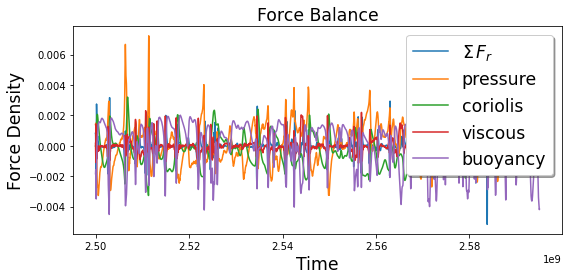

In [3]:
#Decide which direction you want to look at (set direction = {radial,theta, or phi})
#This is used to determine the correct quantity codes below
radial = 0
theta  = 1
phi    = 2
direction=radial
# Build a list of all files ranging from iteration 0 million to 1 million
files = build_file_list(imin,imax,path=model_dir+'Point_Probes')
nfiles = len(files)-1


for i in range(nfiles):
    pp = Point_Probes(files[i],path='')
    if (i == 0):
        nphi = pp.nphi
        ntheta = pp.ntheta
        nr = pp.nr
        nq = pp.nq
        niter = pp.niter
        vals=numpy.zeros( (nphi,ntheta,nr,nq,niter*nfiles),dtype='float64')
        time=numpy.zeros(niter*nfiles,dtype='float64')
    vals[:,:,:,:, i*niter:(i+1)*niter] = pp.vals
    time[i*niter:(i+1)*niter]=pp.time

##################################################
# We choose the coordinate indices **within**
# the Point-Probe array that we want to examine
# These indices start at zero and run to n_i-1
# where n_i is the number of points sampled in 
# the ith direction

# Use help(pp) after loading the Point-Probe file
# to see the Point-Probe class structure

pind = 0           # phi-index to examine
rind = 0           # r-index to examine
tind = 0           # theta-index to examine


pp   = Point_Probes(files[nfiles],path='')
lut  = pp.lut

nt   = pp.niter


#######################################################################
#  Grab velocity or mass flux from the point probe data
base_index = 201
if (model_type == 2):
    base_index = 1
u  = vals[pind,0,rind,pp.lut[base_index+direction],:]
dt=time[1]-time[0]


###########################################################################
# Use numpy to compute time-derivative of u
# (necessary to compute a smooth effective pressure without outputing every timestep)

#Depending on Numpy version, gradient function takes either time (array) or dt (scalar)
try:
    dudt = numpy.gradient(u,time)
except:
    dt = time[1]-time[0]  # Assumed to be constant...
    dudt = numpy.gradient(u,dt) 



################################################################
#      Forces (modulo pressure)
# Note the minus sign for advection.  Advective terms are output as u dot grad u, not -u dot grad u
advec = -vals[ pind, tind, rind, lut[1201 + direction], :] 
cor   = vals[ pind, tind, rind, lut[1219 + direction], :]
visc  = vals[ pind, tind, rind, lut[1228 + direction], :]
forces = visc+cor+advec
if (direction == radial):
    buoy  = vals[ pind, tind, rind, lut[1216], :]
    forces = forces+buoy


############################################3
# Construct effective pressure force
pres = dudt-forces
forces = forces+pres
############################################################
# Set up the plot
yfsize='xx-large'  # size of y-axis label

ustrings = [r'u_r', r'u_\theta', r'u_\phi']
ustring=ustrings[direction]
dstring = r'$\frac{\partial '+ustring+'}{\partial t}$'
fstrings = [r'$\Sigma\,F_r$' , r'$\Sigma\,F_\theta$' , r'$\Sigma\,F_\phi$' ]
fstring = fstrings[direction]
diff_string = dstring+' - '+fstring

pstring = 'pressure'
cstring = 'coriolis'
vstring = 'viscous'
bstring = 'buoyancy'
fig, ax = plt.subplots(figsize=(8, 4))


########################################
# Upper: dur/dt and F_total


ax.plot(time,forces, label = fstring)
ax.plot(time,pres,label=pstring)
ax.plot(time,cor,label=cstring)
ax.plot(time,visc,label=vstring)
if (direction == radial):
    ax.plot(time,buoy,label=bstring)
ax.set_xlabel('Time', size=yfsize)

ax.set_ylabel('Force Density', size=yfsize)
ax.set_title('Force Balance',size=yfsize)

leg = ax.legend(loc='upper right', shadow=True, ncol = 1, fontsize=yfsize) 




plt.tight_layout()
plt.show()
